Date
2000M01    28.2
2000M02    27.7
2000M03    27.9
2000M04    25.7
2000M05    23.1
Name: BrisbaneMax, dtype: float64


Date
2000M01    11.2
2000M02     9.9
2000M03    13.5
2000M04    18.7
2000M05    24.0
Name: TokyoMax, dtype: float64


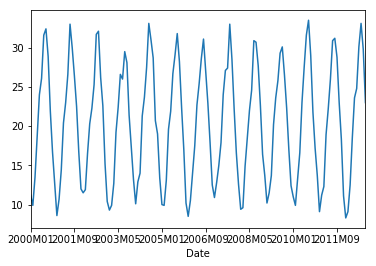

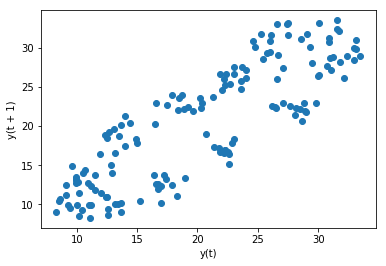

Date
2000M01    23.4
2000M02    23.4
2000M03    22.6
2000M04    20.2
2000M05    18.0
Name: AucklandMax, dtype: float64


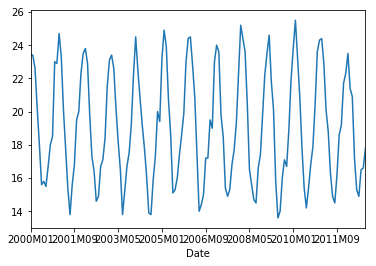

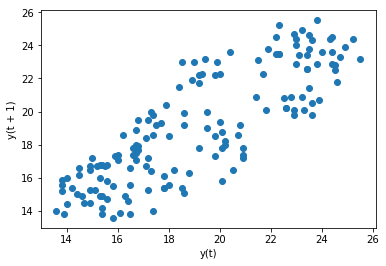

Date
2000M01    19.6
2000M02    18.9
2000M03    18.6
2000M04    20.2
2000M05    21.9
Name: LosAngelesMax, dtype: float64


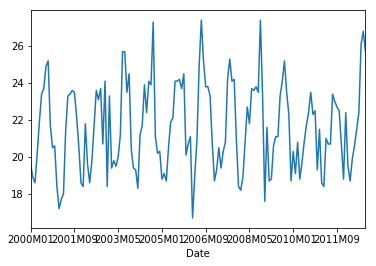

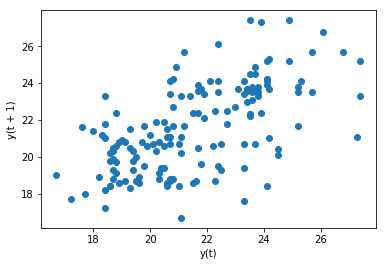

In [156]:
# ---- Explore Dataset ----
from pandas import Series
from matplotlib import pyplot
from pandas.plotting import lag_plot

def explore_time_series_data(path_file):
    series = Series.from_csv(path_file, header=0)
    print(series.head(5)) #head table
    series.plot() #time series 
    pyplot.show()
    lag_plot(series) #check autocorrelation 
    pyplot.show()

# data set 1
explore_time_series_data('data/TempAustralia.csv')
explore_time_series_data('data/TempAsia.csv')
explore_time_series_data('data/TempNZ.csv')
explore_time_series_data('data/TempUSA.csv')

154


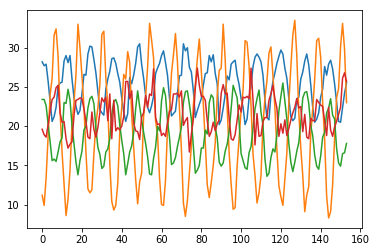

In [157]:
# ---- Cleaning & Rearrange Dataset ----
from pandas import Series
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
import numpy as np

# dataset 1
series1 = Series.from_csv('data/TempAustralia.csv', header=0)
series2 = Series.from_csv('data/TempAsia.csv', header=0)
series3 = Series.from_csv('data/TempNZ.csv', header=0)
series4 = Series.from_csv('data/TempUSA.csv', header=0)

# make key:value structure to 2-dimensional labeled data structure 
values1 = DataFrame(series1.values) 
values2 = DataFrame(series2.values) 
values3 = DataFrame(series3.values) 
values4 = DataFrame(series4.values) 

# add multi data to the same set
dataframe = concat([values1, values2, values3, values4], axis=1)
# dataframe = concat([values1, values2, values4], axis=1)
data_arr = np.array(dataframe)
data_tran = data_arr.transpose()

print(len(data_arr))
pyplot.plot(data_arr)
pyplot.show()

In [158]:
# for AR model : y(t) = c + A1*y(t-1) + A2*y(t-2) + ... Ap*y(t-p)
# y(t) is n x 1 vector

# Input :
# − data is the datasets (format data = [y(1) y(2) ... y(N)])
#   yx(t) is the value of data at time equals to t.
#       example :
#                 |  y1(1)  y1(2)  ... y1(N)  |   
#                 |  y2(1)  y2(2)  ... y2(N)  |
#       data  =   |    .      .          .    | ; n is the dimension of time series
#                 |    .      .          .    |   N is the number of time points in the data
#                 |  yn(1)  yn(2)  ... yn(N)  |
#  
# - p is the lag-order of AR model.

# Output:
# - c is estimated parameter of AR model
#   c is n x 1 vector
# - Ahat is estimated parameter of AR model
#   Ahat = (A1, A2, ..., Ap)
# - Yhat is estimated of data
# - deltaY is data(p+1:N) - Yhat(p+1:N)
# - SIGMAhat is covariance matrix
# ------------------------------------------------------------------------------
import numpy as np

def ARestLS(data,p):
    n = len(data)    # num of all signals
    N = len(data[0]) # num of all time point (equal all signal)

    Y = data[:,p:N]  # Y = all row  & column p+1 to N of data
                     # because model is require p parameter for predict next step
    
    # create H matrix
    H = np.ones(N-p) # first row [1 1 1 ... 1] มี 1 N-p ตัว เช่น 1000-15 = 985 ตัว
    for i in range(p):
        # add second row , third row and the orther        
        H = np.vstack((H,data[:,p-i:N-i]))    
        
    HHT = np.dot(H,H.transpose())
    
    #check if H*H’ is NOT invertible, return an error message
    try:
        invHHT = np.linalg.inv(HHT)
    except np.linalg.LinAlgError:
        # Not invertible
        return "H*H' matrix is close to singular or badly scaled, you can try to change p"
    else:
        YHT = np.dot(Y,H.transpose())

    Aest = np.dot(YHT,invHHT) # Aest = Y*H’/(H*H’) = [c A1 A2 ... Ap] 
    Yhatm = np.dot(Aest,H)
    c = Aest[:,0] # then Aest = [c A1 A2 ... Ap] 
    AestNotC = Aest[:,1:] # AestNotC = [A1 A2 ... Ap] (nx(np))

    #แปลง AestNotC เป็น (nxn) p ก้อน = A1, A2, ..., Ap
    Ahat = [] 
    for j in range(p):
        Aj = AestNotC[:,j*n:(j+1)*n]
        Ahat.append(Aj)

    Yhat = np.hstack((data[:,0:p],Yhatm)) # ทำให้ข้อมูล predict เท่ากับข้อมูลตั้งต้น
    deltaY = Y-Yhatm #Y−Yest when p+1−N 
    SIGMAhat = (1/(N-p))*np.dot(deltaY,deltaY.transpose())
    output = []
    output.append(c)
    output.append(Ahat)
    output.append(Yhat)
    output.append(deltaY)
    output.append(SIGMAhat)
    return output

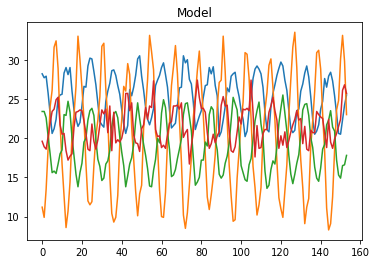

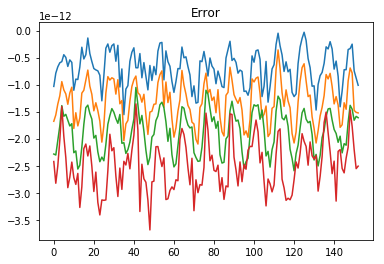

In [159]:
# ---- Explore VAR Model ----
# ---- Example p = 1 ----
EstOutput = ARestLS(data_tran,1)
c = EstOutput[0]
Ahat = EstOutput[1]
Yhat = EstOutput[2]
deltaY = EstOutput[3]
SIGMAhat = EstOutput[4]

YhatTr = Yhat.transpose()

pyplot.plot(data_arr)
pyplot.title('Data Set')
pyplot.show()

pyplot.plot(YhatTr)
pyplot.title('Model')
pyplot.show()

pyplot.plot(deltaY.transpose())
pyplot.title('Error')
pyplot.show()

In [160]:
# ------------BIC score and Trade off Curve ---------------
# % Input:
# % - deltaY is the difference matrix of data and estimated data.
# %   example: deltaY = Y-Yest when p+1-N; Y is data, Yest is estimated data,                                        
# % - Sigma is the covariance matrix of AR model.
# % - p is the lag-order of AR model, that you want to know score.

# % Output:
# % - BIC score

import numpy as np
from math import log

def BIC_ARmodel(deltaY, Sigma, p):
    # get parameter
    [n,Nminusp] = np.shape(deltaY) # get n and (N−p) 
    N = Nminusp+p;

    # find right part of log−likelihood function 
    ivSigma = np.linalg.inv(Sigma)
    rLogli = 0
    for t in range(0,Nminusp): 
        deltaYt = deltaY[:,t]
        rLogli = rLogli + np.dot(np.dot(deltaYt.transpose(), ivSigma), deltaYt)
    # find BIC score at order p
    L = ((N-p)/2)*log(np.linalg.det(ivSigma)) - (1/2)*rLogli
    d = n*(n*p+1)
    BIC = -2*L + d*log(N)     
    return BIC

In [161]:
# ---- Plot BIC Score ----
# INPUT :
# - data_tran
# - range
# OUTPUT :
# - graph
# - number of order

def plot_bic_score(data,max_order):
    bic_arr = []
    min_positive_bic = 0
    for i in range(max_order):
        EstOutput = ARestLS(data,i+1) # estimate AR Model at order = p
        deltaY = EstOutput[3]         
        SIGMAhat = EstOutput[4]        

        score = BIC_ARmodel(deltaY, SIGMAhat, i+1) # BIC score at order = p

        bic_arr.append((i+1, score))
        if (min_positive_bic != 0):
            if(score < min_positive_bic):
                min_positive_bic = i+1 
        else:    
            if (score > 0):
                min_positive_bic = i+1

    print("Best order from BIC score :",min_positive_bic)
    pyplot.plot(bic_arr)
    pyplot.show() 
    return min_positive_bic

In [162]:
# ------------Create Avec Matrix ---------------
# INPUT :
# - Ahat is estimated parameter of AR model. 
#   Ahat = (A1,A2,...,Ap)  has size (n,n,p)
# OUTPUT :
# - Avec is estimated A matrix into a vector form.
#   Avec has size n^2*p x 1 (ดู ได้จากโครงงานไอ้นัด theta)
import numpy as np

def ARLSvec(Ahat):
    # parameter 
    [p,n,n] = np.shape(Ahat) # Ahat = [A1 A2 ... Ap] that Ai is nxn matrix
    
    # convert Ahat matrix into a vector form
    Avec = []
    for i in range(n):
        for j in range(n):
            for k in range(p):
                Avec.append(Ahat[k][i,j]) # Avec is theta

    return Avec

In [163]:
# ------------create Avar Matrix ---------------
# INPUT:
# - data is the datasets of EEG signal, data = [y(1) y(2) ... y(N)]. 
#   yx(t) is the value of data at time equals to t.
# example: 
#             | y1(1) y1(2) .... Y1(N) |
#             | y2(1) y2(2) .... y2(N) |    
#      data = |   .     .          .   |  ; n is the dimension of time series, 
#             |   .     .          .   |    N is the number of time points in the data
#             | yn(1) yn(2) .... yn(N) |
# 
# - p is the lag-order of AR model.
# - Sigma is covariance matrix.

# OUTPUT:
# - Avar is consistent estimate of the asymptotic covariance matrix of Avec.
#   Avar has size n^2*p x n^2*p (ดู ได้จากโครงงานไอ้นัด แถวๆ Hbar)
import numpy as np

def ARLSvar(data,p,Sigma):
    #  parameter
    [n,N] = np.shape(data)

    # compute Avar from   
    ivAvar = np.zeros(n*n*p)
    for t in range(p,N):
        Yit = data[:,t-p:t] # [ y(t-p) ... y(t-2) y(t-1) ] 
        Yflip = np.fliplr(Yit) # [ y(t-1) y(t-2) ... y(t-p) ] 
        
        ybar = Yflip.reshape(-1,1) # 1 column automatically calculate the appropriate number of rows.
        Hbar = np.kron(np.identity(n),ybar.conj().transpose())

        ivSigma = np.linalg.inv(Sigma)
        ivAvar = ivAvar + np.dot(np.dot(Hbar.conj().transpose(),ivSigma),Hbar)

    Avar = np.linalg.inv(ivAvar)
    return Avar

In [164]:
# ------------Inverse-chi-squared distribution function---------------
# INPUT :
# - x is 1-alpha
# - p is degrees of freedom.

# OUTPUT :
# - c is a critical value
from scipy.stats import gamma

def chi2inv(x, p):
    inv = gamma.ppf(x,p/2,scale=2)    
    return inv    

In [165]:
# ----------- Wald test for AR model with--------------
# INPUT :
# - n is the dimension of the model output
# - p is the lag-order of the model
# - Avec is estimated A matrix into a vector form. Avec has size n^2*p x 1.
# - Avar is a consistent estimate of the asymptotic covariance matrix of Aest
# - alpha is a significance level of the test

# OUTPUT :
# - S is zero structure of estimated model parameter
# - W is Wald
import numpy as np
from PIL import Image

def funcWaldTest(n,p,Avec,Avar,alpha):
    # --- Wald test ---
    W = np.zeros((n,n))
    c = chi2inv(1-alpha,p) # a critical value
    # print("Critical value :",c) 

    Cvec = [c+1] * n
    Cdiag = np.diag(Cvec)

    W = W + Cdiag

    # create Bhat = [Bij] = r(thetahat) from Avec = (B11,B12,...,B1n);...;(Bn1,Bn2,...,Bnn)    
    # r = [rij] >> rij = r[i,j]
    r = {}
    ni = 0
    for i in range(n):
        for j in range(n):
            r[i,j] = Avec[ni*p:(ni+1)*p] 
            ni+=1
            
    # create Wald matrix        
    nsquar = 0
    for i in range(n): #(1:n)
        for j in range(n): #(1:n)
            rij = np.array(r[i,j])            
            Avarij = Avar[nsquar*p:(nsquar+1)*p, nsquar*p:(nsquar+1)*p]
            invAvarij = np.linalg.inv(Avarij)
            W[i,j] = np.dot(np.dot(rij.conj().transpose(),invAvarij),rij) # Wald statistic value
            nsquar = nsquar+1

    S = W > c # True, False structure
    S = S*1   # 0, 1 structure

    # diagonal entries of S should be assigned to 1
    for i in range(n):
        S[i,i]=1

    return [S,W]

In [166]:
# -------Scale Wald Matrix--------
def scale_wald_matrix(W):
    n = len(W)
    
    # scale W matrix 
    w_max = W.max()
    scaled_w = (1/w_max)*W
    S = scaled_w > 0.05 # True, False structure
    S = S*1   # 0, 1 structure
    scaled_w = scaled_w*S
    
    # diagonal entries of S should be assigned to 1
    for i in range(n):
        scaled_w[i,i]=1
        S[i,i]=1
    
    return [S,scaled_w]

In [167]:
# --------Display matrix----------
from matplotlib import pyplot

def display_sw(S,W):
    # Display matrix
    pyplot.matshow(W, cmap=pyplot.cm.gray_r)
    pyplot.title('Correlation Structure',y=1.1)
    pyplot.colorbar()
    pyplot.show()
    pyplot.matshow(S, cmap=pyplot.cm.gray_r)
    pyplot.title('Binary Structure',y=1.1)
    pyplot.colorbar()
    pyplot.show()

Best order from BIC score : 31


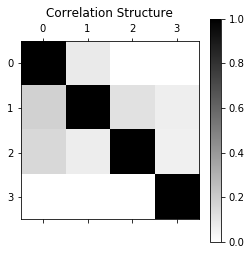

[[ 553.68425657   47.29529517    0.            0.        ]
 [ 100.00000277  553.68425657   66.15163172   37.71036695]
 [  84.36353605   38.98428393  553.68425657   33.08372045]
 [   0.            0.            0.          553.68425657]]


In [168]:
# -------Estimate Best Order Model--------
n = len(data_tran)
p = plot_bic_score(data_tran,100) 
EstOutput = ARestLS(data_tran,p)
c = EstOutput[0]
Ahat = EstOutput[1]
Yhat = EstOutput[2]
deltaY = EstOutput[3]
SIGMAhat = EstOutput[4]

Avec = ARLSvec(Ahat)
Avar = ARLSvar(data_tran,p,SIGMAhat)
alpha = 0.5
[S,W] = funcWaldTest(n,p,Avec,Avar,alpha)
[new_s,new_w] = scale_wald_matrix(W)
display_sw(new_s,new_w)
print(new_w*100/0.18060835)